# Deformation in and around Askja volcano, Iceland

<div style="text-align: justify">

In this example notebook we create, from scratch, a basic model for the deformation field at Askja volcano, Iceland. From this model we compute and visualise the displacement, strain, and stress fields in and around the volcano.

<hr>

This example is based on modelling originally performed for:

> `Bacon, C.A., Johnson, J.H., White, R.S. and Rawlinson, N., 2022. On the origin of seismic anisotropy in the shallow crust of the Northern Volcanic Zone, Iceland. Journal of Geophysical Research: Solid Earth, 127(1), p.e2021JB022655.`
> 
<hr>

This example is a Jupyter "notebook"—a browser-based platform that allows developers to code, visualise, and add additional explanatory text inside a single document. Treat it as a Python script that you can edit and re-run sections of on the fly.

As is standard with any Python script, we import all of the modules required to run everything at the top.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer

import okada.plot
from okada import evaluate, read_model, Model
from okada.elements.point_source import PointInflation
from okada.elements.tensile_crack import TensileCrack

## Building the deformation model

<div style="text-align: justify">

There a number of different mechanisms contributing to the overall deformation field in and around Askja. As we are treating the problem as a linear elastic one, we can compute the contributions from each constituent part of the model and stack them linearly to find the final deformation field.

There are two primary contributions to deformation in the Northern Volcanic Zone around Askja:

1. the deformation associated with extension (plate-spreading) along the divergent margin. Previous work has treated this extension as a buried dislocation—that is, opening on a tensile crack that extends from some locking depth to infinite. Above the locking depth, the opening of the tensile crack diminishes to zero (or, in order to avoid singularities, the _gradient_ of the opening tends to zero at some depth). This depth is derived from the observed brittle-ductile transition in the crust, as determined from earthquake hypocentres across the Northern Volcanic Zone;
2. and deflation centred underneath Askja caldera modelled as a infinitesimal point source (a "Mogi"-like source), the potency of which has been constrained by geodetic observations across Askja made since the 1980s.

The contributions from plate-spreading are distributed across the rift segments that accompany the central volcanoes along the Northern Volcanic Zone. The tensile-opening potency is taken to be equal to the far-field plate-spreading speed.

We start by defining a number of basic elastic parameters, the values of which are approximations that are appropriate for this region:
</div>

In [2]:
poisson_ratio = 0.25
youngs_modulus = 450_000
friction_coefficient = 0.4  # Not actually used

<div style="text-align: justify">

Next, we define the coordinates in space on which we wish to compute our analytical solutions to the model. Here we use a simple, regular Cartesian grid (90 km by 120 km, with a node spacing of 1 km), but it is entirely possible to use any x/y coordinate sets.

We tie this Cartesian grid to our geographic coordinate space with a projection transformation, using the `PYPROJ` package, and a reference point which in this instance is equivalent to the (0, 0) origin of the Cartesian grid.
</div>

In [3]:
x_inc = 1.0
x_coords = np.arange(0.0, 90.0 + x_inc, x_inc)
x_coords = np.ascontiguousarray(x_coords, dtype=np.float64)

y_inc = 1.0
y_coords = np.arange(0.0, 120.0 + y_inc, y_inc)
y_coords = np.ascontiguousarray(y_coords, dtype=np.float64)

x_coords, y_coords = np.meshgrid(x_coords, y_coords, indexing="ij")

transformer = Transformer.from_crs(
    crs_from="EPSG:4326", crs_to="EPSG:32628", always_xy=True
)
reference_coords = (-17.6, 64.5)
REF_X, REF_Y = transformer.transform(*reference_coords)

<div style="text-align: justify">

Now we can proceed with building our model by defining its constituent elements, starting with the deflation source.

The parameters for our point source of deflation are taken from direct inversions of geodetic data (both GNSS and InSAR data) recorded across the Northern Volcanic Zone. These best-fitting models are presented in:

> `Drouin, V., Sigmundsson, F., Ófeigsson, B.G., Hreinsdóttir, S., Sturkell, E. and Einarsson, P., 2017. Deformation in the Northern Volcanic Zone of Iceland 2008–2014: An interplay of tectonic, magmatic, and glacial isostatic deformation. Journal of Geophysical Research: Solid Earth, 122(4), pp.3158-3178.`

From Table 4 in this paper, we get the following Mogi parameters for Askja:

* Depth: 3.5 km
* Latitude: 65.050
* Longitude: −16.778
* dV: -0.99 m^3 / yr

We can use our coordinate transformer, along with our reference point (the (0.0, 0.0) coordinate origin of the grid, in this case) to put this into our Cartesian space.
</div>

In [4]:
mogi_coords = (-16.778, 65.050, 3.5)
mogi_x, mogi_y, mogi_z = transformer.transform(*mogi_coords)
mogi_x = round((mogi_x - REF_X) / 1000, ndigits=3)
mogi_y = round((mogi_y - REF_Y) / 1000, ndigits=3)

In [5]:
deflation_source = PointInflation(
    x_start=mogi_x,
    x_end=mogi_x + 0.001,
    y_start=mogi_y,
    y_end=mogi_y + 0.001,
    z_start=mogi_z + 0.001,
    z_end=mogi_z,
    dip_angle=90.0,
    tensile_opening=0.0,
    point_opening=-0.99e6,  # This is the opening potency, with units of m^3
)

<div style="text-align: justify">

The rift segments are built as a composite of tensile-opening cracks, where the amount of opening is a monotonic function with depth between 5.75 km (the 'locking depth', above which the crust is in an entirely brittle regime) and 7 km (below which the crust is in an entirely ductile regime). Below 7 km, opening equals the full plate-spreading rate (in this case 18 mm / year).

We use here a cubic polynomial as our monotonic function, tuned so as to guarantee a zero gradient at both ends of the depth range.
</div>

In [6]:
def opening_distribution(
    z: float, z_lock: float, z_bd: float, spreading_rate: float, method: str = "cubic"
) -> float:
    """
    Calculate plate-spreading as a function of depth.

    Parameters
    ----------
    z: Depth (positive downward).
    z_lock: Locking depth.
    z_bd: Brittle-ductile transition depth.
    spreading_rate: Full plate-spreading rate.
    method: Specify the function to be used to compute the opening.

    Returns
    -------
    opening: Plate opening at depth z.

    """

    if z <= z_lock:  # Above locking depth
        opening = 0
    elif z >= z_bd:  # Below brittle-ductile transition
        opening = spreading_rate
    else:  # Transition zone
        # Normalize depth to [0,1] interval
        zn = (z - z_lock) / (z_bd - z_lock)

        if method == "cubic":
            # Cubic polynomial satisfying boundary conditions
            # f(0) = 0, f'(0) = 0, f(1) = spreading_rate, f'(1) = 0
            opening = spreading_rate * (3 * zn**2 - 2 * zn**3)
        elif method == "quintic":
            # Quintic polynomial
            # f(0) = 0, f'(0) = 0, f''(0) = 0
            # f(1) = spreading_rate, f'(1) = 0, f''(1) = 0
            opening = spreading_rate * (10 * zn**3 - 15 * zn**4 + 6 * zn**5)
        elif method == "linear":
            # Linear transition
            # f(0) = 0, f(1) = spreading_rate
            opening = spreading_rate * zn
        else:
            raise ValueError("Method must be either 'linear' or 'cubic' (default).")

    return opening

<div style="text-align: justify">

We can quickly visualise what three different opening distributions look like: 'linear', 'cubic', and 'quintic':
</div>

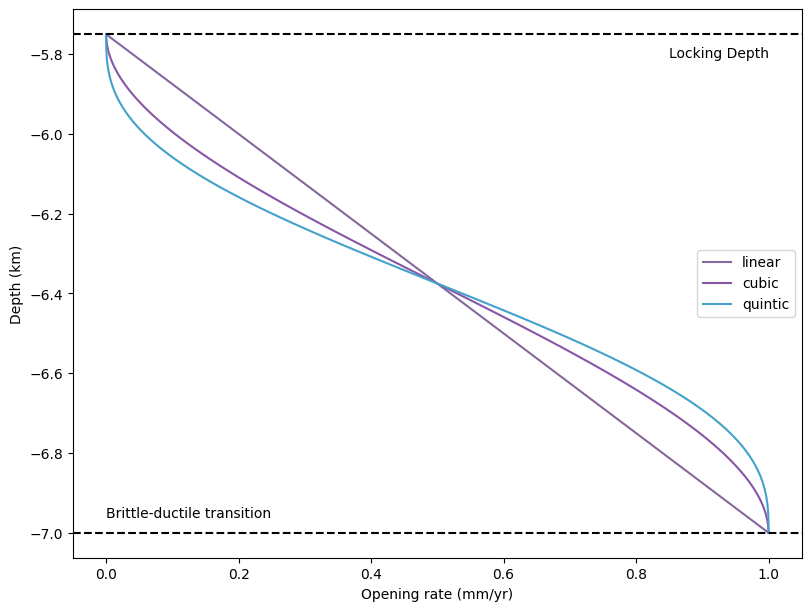

In [7]:
locking_depth = 5.75  # km
brittle_ductile_depth = 7.0  # km
sample_points = 126  # Number of points to sample across the boundary
z = np.linspace(locking_depth, brittle_ductile_depth, sample_points)
z_increment = z[1] - z[0]

fig, ax = plt.subplots(1, figsize=(8, 6), constrained_layout=True)

for method, c in zip(["linear", "cubic", "quintic"], ["#84679F", "#8856a7", "#43a2ca"]):
    opening = [
        opening_distribution(
            zi, locking_depth, brittle_ductile_depth, 1.0, method=method
        )
        for zi in z
    ]

    ax.plot(opening, -z, c=c, label=method)

ax.axhline(-locking_depth, color="k", linestyle="--")
ax.text(1.0, -5.78, "Locking Depth", ha="right", va="top")
ax.axhline(-brittle_ductile_depth, color="k", linestyle="--")
ax.text(0.0, -6.97, "Brittle-ductile transition", ha="left", va="bottom")
ax.set_xlabel("Opening rate (mm/yr)")
ax.set_ylabel("Depth (km)")
_ = plt.legend()

Now, we loop over each rift segment (each corresponding to a central volcano) and build our buried dislocation model:

In [8]:
rift_segments = [
    [(-17.000, 64.810), (-16.400, 65.400), 0.018],  # Askja
    [(-16.650, 64.650), (-16.050, 65.050), 0.002],  # Krafla - assuming less active
    [(-17.464, 64.600), (-17.070, 64.930), 0.018],  # Bardarbunga
    [(-16.750, 65.300), (-16.600, 65.500), 0.018],  # Namafjall
]

rift_elements = []
for rift_segment in rift_segments:
    start_coord, end_coord, spreading_rate = rift_segment
    x_start, y_start = transformer.transform(*start_coord)
    x_end, y_end = transformer.transform(*end_coord)

    x_start, x_end = [round((x - REF_X) / 1000, ndigits=3) for x in [x_start, x_end]]
    y_start, y_end = [round((y - REF_Y) / 1000, ndigits=3) for y in [y_start, y_end]]
    opening = [
        opening_distribution(
            zi, locking_depth, brittle_ductile_depth, spreading_rate, method="cubic"
        )
        for zi in z
    ]
    for o, zi in zip(opening, z):
        if zi == brittle_ductile_depth:
            # Final element spanning from brittle-ductil depth to 'infinity'
            z_lower = 100.0
        else:
            z_lower = round(zi + z_increment, ndigits=3)
        element = TensileCrack(
            x_start,
            x_end,
            y_start,
            y_end,
            round(zi, ndigits=3),
            z_lower,
            90.0,
            tensile_slip=round(o, ndigits=5),
        )
        rift_elements.append(element)

We now combine everything into a `Model` object, which we use as an input for `OkadaPy` computations.

In [9]:
elements = [deflation_source, *rift_elements]

model = Model(
    poisson_ratio,
    youngs_modulus,
    friction_coefficient,
    elements,
    x_coords.flatten(),
    y_coords.flatten(),
    transformer=transformer,
)

# Evaluate displacement, strain, and stress at 0.0 km depth
depth = 0.0
n_threads = 16
displacement_result = evaluate(model, depth, "displacement", threads=n_threads)
strain_result = evaluate(model, depth, "strain", threads=n_threads)
stress_result = evaluate(model, depth, "stress", threads=n_threads)

	Computing displacement solution...
		Elapsed time: 0.684848 seconds.
	...complete.
	Computing strain solution...
		Elapsed time: 0.785812 seconds.
	...complete.
	Computing stress solution...
		Elapsed time: 0.785504 seconds.
	...complete.


(45.0, 80.0)

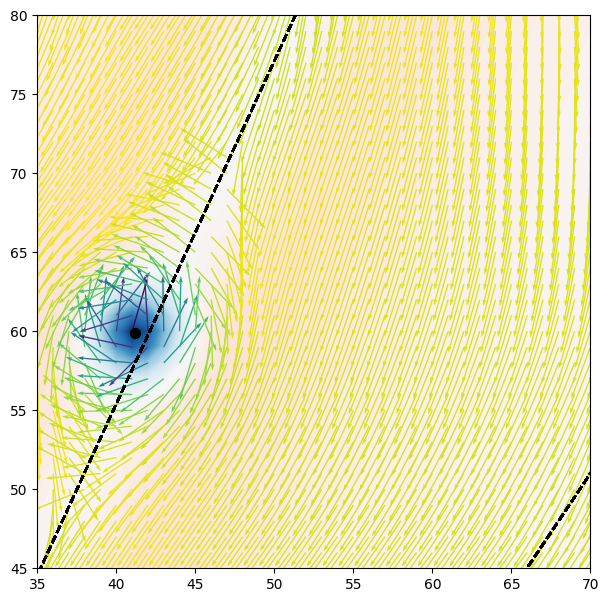

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18.5 / 2.54, 15 / 2.54), constrained_layout=True)

_ = okada.plot.strain(
    model,
    strain_result.strain,
    "DIL",
    ax=ax,
    coordinate_space="cartesian",
)

_ = okada.plot.shmax_vectors(
    model,
    stress_result,
    ax=ax,
    coordinate_space="cartesian",
)

for element in model.elements:
    if isinstance(element, PointInflation):
        x = (element.x_end + element.x_start) / 2
        y = (element.y_end + element.y_start) / 2
        ax.scatter(
            x,
            y,
            c="k",
            marker="o",
            s=50,
        )

    if isinstance(element, TensileCrack):
        ax.plot(
            [element.x_start, element.x_end], [element.y_start, element.y_end], "k--"
        )

ax.set_xlim([35, 70])
ax.set_ylim([45, 80])

<div style="text-align: justify">

The above gives an overview of the process of developing a relatively simple deformation model, but it is absolutely possible to extend this to ever more complex models! Alternatively, `OkadaPy` has a simple interface for parsing pre-existing Coulomb3.4 input files. For the above example, we can read in the original Coulomb input file used for Bacon et al. (2022).

This is as simple as:
</div>

In [11]:
model = read_model("conorbacon_ds01.inp", "COULOMB")
model.transformer = transformer

# Evaluate displacement, strain, and stress at 0.0 km depth
depth = 0.0
n_threads = 16
displacement_result = evaluate(model, depth, "displacement", threads=n_threads)
strain_result = evaluate(model, depth, "strain", threads=n_threads)
stress_result = evaluate(model, depth, "stress", threads=n_threads)

	Reading in model from conorbacon_ds01.inp...
		Coulomb-style .inp file identified.
	...read successful.
	Computing displacement solution...
		Elapsed time: 0.670151 seconds.
	...complete.
	Computing strain solution...
		Elapsed time: 0.777847 seconds.
	...complete.
	Computing stress solution...
		Elapsed time: 0.706791 seconds.
	...complete.


(45.0, 80.0)

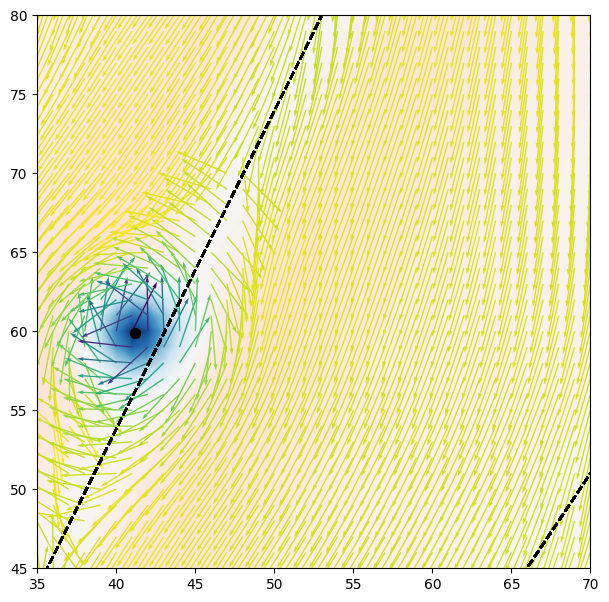

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18.5 / 2.54, 15 / 2.54), constrained_layout=True)

_ = okada.plot.strain(
    model,
    strain_result.strain,
    "DIL",
    ax=ax,
    coordinate_space="cartesian",
)

_ = okada.plot.shmax_vectors(
    model,
    stress_result,
    ax=ax,
    coordinate_space="cartesian",
)

for element in model.elements:
    if isinstance(element, PointInflation):
        x = (element.x_end + element.x_start) / 2
        y = (element.y_end + element.y_start) / 2
        ax.scatter(
            x,
            y,
            c="k",
            marker="o",
            s=50,
        )

    if isinstance(element, TensileCrack):
        ax.plot(
            [element.x_start, element.x_end], [element.y_start, element.y_end], "k--"
        )

ax.set_xlim([35, 70])
ax.set_ylim([45, 80])